In [101]:
import numpy as np
import cv2
from torch.utils.data import Dataset
import torch
from torchvision import models
import os
from torchvision.models.segmentation import DeepLabV3_MobileNet_V3_Large_Weights
from torch.utils.data import DataLoader
from IPython.display import clear_output
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import albumentations as A
import pandas as pd
from PIL import Image


In [8]:
def create_mask(quad, img_shape):
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    quad = np.array(quad, dtype=np.int32)
    cv2.fillPoly(mask, [quad], 1)
    return mask

In [61]:
class EAN13(Dataset):
    def __init__(self, path):
        self.transform = A.Compose([
            A.Resize(height=256, width=256, p=1),
            A.Rotate(limit=(20, 340), p=0.5)
        ])
        self.markup = pd.read_csv(os.path.join(path, "markup.csv"), encoding="utf-16")
        self.path = path
        
    def __getitem__(self, idx):
        row = self.markup.iloc[idx]
        image_path = os.path.join(self.path, "Images", row.image_path)
        img = np.array(Image.open(image_path).convert('RGB'))
        quad = np.array([[row.x1, row.y1],
                         [row.x2, row.y2],
                         [row.x3, row.y3],
                         [row.x4, row.y4],])
        
        mask = create_mask(quad, img.shape)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        return torch.tensor(img).permute(2, 0, 1).float(), torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

    def __len__(self):
        return len(self.markup)

In [62]:
dataset = EAN13("CourseOCRTask3/Train")
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [63]:
device = torch.device("cuda")

In [71]:
model = models.segmentation.deeplabv3_mobilenet_v3_large(DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1)
model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=1)
model.to(device);

/mnt/sdb/nikita_shevchenko/task3/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [72]:
class Loss(torch.nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.bce = torch.nn.BCEWithLogitsLoss()
        
    def forward(self, pred, target):
        smooth = 1.
        iflat = pred.contiguous().view(-1)
        tflat = target.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        dice = 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )
        bce = self.bce(pred, target)
        return 0.4 * dice + 0.6 * bce

In [73]:
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 2 * len(dataloader))
criterion = Loss()

In [74]:
def train_model(model, dataloader, optimizer, criterion, num_epochs=1):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        for batch, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            if batch % 10 == 0:
                clear_output(wait=True)
                plt.plot(losses, label='Training Loss')
                plt.show()

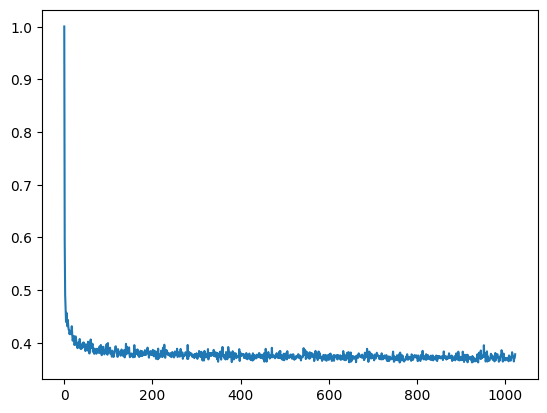

In [75]:
train_model(model, dataloader, optimizer, criterion, num_epochs=2)

In [133]:
def mask_to_quad(mask):
    binary_mask = (mask > 0).cpu().numpy().astype(np.uint8)
    contours, _ = cv2.findContours(binary_mask.squeeze(0), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        contour = max(contours, key=cv2.contourArea)
        x, y = contour[:, 0, 0], contour[:, 0, 1]

        corners_indices = np.array([np.argmin(x + y), np.argmin(-x + y), np.argmax(x + y), np.argmax(-x + y)])
        corners = np.array([x[corners_indices], y[corners_indices]]).T

        return corners.astype(float)
    return np.zeros((4, 2), dtype=float)

In [179]:
class TestEAN13(Dataset):
    def __init__(self, path):
        self.transform = A.Compose([
            A.Resize(height=256, width=256, p=1),
        ])
        self.image_paths = [os.path.join(path, image_path) for image_path in os.listdir(path)]

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        img = np.array(Image.open(image_path).convert('RGB'))
        h, w = img.shape[0], img.shape[1]
        transformed = self.transform(image=img)
        img = transformed['image']

        return torch.tensor(img).permute(2, 0, 1).float(), self.image_paths[idx].split('/')[-1], h, w

    def __len__(self):
        return len(self.image_paths)

In [180]:
dataset = TestEAN13("/home/nikita_shevchenko/task3/CourseOCRTask3/Test/Images")
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [182]:
corners = []
image_name = []
model.eval()
with torch.no_grad():
    for image, name, h, w in tqdm(dataloader):
        mask = model(image.to(device))['out']
        quad = mask_to_quad(mask.squeeze(0))
        scale_w = w.item() / 256
        scale_h = h.item() / 256
        quad[:, 0] *= scale_w
        quad[:, 1] *= scale_h
        corners.append(quad)
        image_name.append(name[0])

100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


In [192]:
data = {
    'a': [f"{name}" for name in image_name],
    'b': ['-'] * len(image_name),
    'x1': [int(quad[0, 0]) for quad in corners],
    'y1': [int(quad[0, 1]) for quad in corners],
    'x2': [int(quad[1, 0]) for quad in corners],
    'y2': [int(quad[1, 1]) for quad in corners],
    'x3': [int(quad[2, 0]) for quad in corners],
    'y3': [int(quad[2, 1]) for quad in corners],
    'x4': [int(quad[3, 0]) for quad in corners],
    'y4': [int(quad[3, 1]) for quad in corners],
    'd':['-'] * len(image_name)
}
pd.DataFrame(data).to_csv('answer.csv', index=False, encoding='utf-16', header=False)
from course_intro_ocr_t3.evaluate import main

main()

Checking answer (/mnt/sdb/nikita_shevchenko/task3/answer.csv) against markup(/mnt/sdb/nikita_shevchenko/task3/markup.csv)
recognition_accuracy=0.0
detection_result=1.0
score=1.0


In [194]:
torch.save(model, "./model.pth")